In [259]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

### Попробуем понять, что значит каждый столбец
Для помощи использовала https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes?select=aac_outcomes.csv

In [260]:
orig_data = pd.read_csv('aac_shelter_outcomes.csv')

In [261]:
orig_data.head()

age_upon_outcome animal_id animal_type                    breed  \
0          2 weeks   A684346         Cat   Domestic Shorthair Mix   
1           1 year   A666430         Dog               Beagle Mix   
2           1 year   A675708         Dog                 Pit Bull   
3          9 years   A680386         Dog  Miniature Schnauzer Mix   
4         5 months   A683115       Other                  Bat Mix   

          color        date_of_birth             datetime  \
0  Orange Tabby  2014-07-07T00:00:00  2014-07-22T16:04:00   
1   White/Brown  2012-11-06T00:00:00  2013-11-07T11:47:00   
2    Blue/White  2013-03-31T00:00:00  2014-06-03T14:20:00   
3         White  2005-06-02T00:00:00  2014-06-15T15:50:00   
4         Brown  2014-01-07T00:00:00  2014-07-07T14:04:00   

             monthyear     name outcome_subtype outcome_type sex_upon_outcome  
0  2014-07-22T16:04:00      NaN         Partner     Transfer      Intact Male  
1  2013-11-07T11:47:00     Lucy         Partner     Transfer    Spayed Female  
2  2014-06-03T14:20:00  *Johnny             NaN     Adoption    Neutered Male  
3  2014-06-15T15:50:00   Monday         Partner     Transfer    Neutered Male  
4  2014-07-07T14:04:00      NaN     Rabies Risk   Euthanasia          Unknown

In [262]:
# смотрим только на 'Transfer', 'Adoption'

In [263]:
data = pd.DataFrame(orig_data[orig_data.outcome_type.isin(['Transfer', 'Adoption'])])

In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56611 entries, 0 to 78255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age_upon_outcome  56609 non-null  object
 1   animal_id         56611 non-null  object
 2   animal_type       56611 non-null  object
 3   breed             56611 non-null  object
 4   color             56611 non-null  object
 5   date_of_birth     56611 non-null  object
 6   datetime          56611 non-null  object
 7   monthyear         56611 non-null  object
 8   name              38660 non-null  object
 9   outcome_subtype   29425 non-null  object
 10  outcome_type      56611 non-null  object
 11  sex_upon_outcome  56611 non-null  object
dtypes: object(12)
memory usage: 5.6+ MB


In [265]:
data.columns

Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome'],
      dtype='object')

* 'age_upon_outcome' - возраст животного на момент принятия решения
* 'animal_id' - id животного
* 'animal_type' - тип животного (Собка/кошка/птица/домашний скот (Livestock)/другое)
* 'breed' - порода
* 'color' - цвет животного
* 'date_of_birth' - дата рождения животного
* 'datetime' - timestamp, когда по животному было принято решение outcome_type
* 'monthyear'-  месяц и год в формате timestamp от datetime
* 'name' - имя животного
* 'outcome_subtype' - более детальное описание outcome_type (где возможно)
* 'outcome_type'- решение о судьбе животного 
* 'sex_upon_outcome' - пол животного + факт стерилизации

In [266]:
data.sex_upon_outcome.value_counts()

Neutered Male    20732
Spayed Female    19949
Intact Female     6874
Intact Male       6295
Unknown           2761
Name: sex_upon_outcome, dtype: int64

### Теперь расшифруем столбец с целевыми значениями (outcome_type)

In [267]:
data.outcome_type.value_counts()

Adoption    33112
Transfer    23499
Name: outcome_type, dtype: int64

* Adoption           - животное забрали из приюта домой
* Transfer           - животное было перемещено в место, где его приютят (в сарай)
* Return to Owner    - животное возвращено владельцу
* Euthanasia         - животное усыпили
* Died               - животное умерло
* Disposal           - удаление животного (???)
* Rto-Adopt          - rto - return-to-owner (непонятно, в чем разница с Return to Owner)
* Missing            - животное пропало
* Relocate           - животное переместили

In [268]:
data.describe()

age_upon_outcome animal_id animal_type                   breed  \
count             56609     56611       56611                   56611   
unique               45     52792           5                    1803   
top              1 year   A732618         Dog  Domestic Shorthair Mix   
freq               9766         6       29570                   20809   

              color        date_of_birth             datetime  \
count         56611                56611                56611   
unique          475                 4883                45158   
top     Black/White  2014-05-05T00:00:00  2016-04-18T00:00:00   
freq           6111                   97                   39   

                  monthyear   name outcome_subtype outcome_type  \
count                 56611  38660           29425        56611   
unique                45158  11989               6            2   
top     2016-04-18T00:00:00  Bella         Partner     Adoption   
freq                     39    204           19660        33112   

       sex_upon_outcome  
count             56611  
unique                5  
top       Neutered Male  
freq              20732

In [269]:
#  Отконвертируем даты

In [270]:
data['date_of_birth'] = pd.to_datetime(data.date_of_birth)
data['datetime'] = pd.to_datetime(data.datetime)

In [271]:
# Месяц и год можно вытащить из datetime - monthyear избыточно

In [272]:
data.drop(['monthyear'], axis=1, inplace=True)

In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56611 entries, 0 to 78255
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  56609 non-null  object        
 1   animal_id         56611 non-null  object        
 2   animal_type       56611 non-null  object        
 3   breed             56611 non-null  object        
 4   color             56611 non-null  object        
 5   date_of_birth     56611 non-null  datetime64[ns]
 6   datetime          56611 non-null  datetime64[ns]
 7   name              38660 non-null  object        
 8   outcome_subtype   29425 non-null  object        
 9   outcome_type      56611 non-null  object        
 10  sex_upon_outcome  56611 non-null  object        
dtypes: datetime64[ns](2), object(9)
memory usage: 5.2+ MB


In [274]:
# describe показал, что animal_id не уникально (??), првоерим - почему

In [275]:
data.animal_id.value_counts().sort_values(ascending=False).head(20)

A732618    6
A703649    5
A738936    5
A740335    5
A741211    5
A683030    5
A739197    5
A612961    4
A760403    4
A718350    4
A676235    4
A711968    4
A731245    4
A698372    4
A671025    4
A669782    4
A758365    4
A720611    4
A700287    4
A727332    4
Name: animal_id, dtype: int64

In [276]:
data[data.animal_id == 'A732618']

age_upon_outcome animal_id animal_type         breed        color  \
28695          2 years   A732618         Dog  Pit Bull Mix  Black/White   
28757          2 years   A732618         Dog  Pit Bull Mix  Black/White   
40568          2 years   A732618         Dog  Pit Bull Mix  Black/White   
41989          2 years   A732618         Dog  Pit Bull Mix  Black/White   
51908          2 years   A732618         Dog  Pit Bull Mix  Black/White   
76797          3 years   A732618         Dog  Pit Bull Mix  Black/White   

      date_of_birth            datetime    name outcome_subtype outcome_type  \
28695    2014-08-10 2017-05-27 17:26:00  *Sidra             NaN     Adoption   
28757    2014-08-10 2016-12-11 17:13:00  *Sidra             NaN     Adoption   
40568    2014-08-10 2016-10-09 14:48:00  *Sidra             NaN     Adoption   
41989    2014-08-10 2017-04-16 12:37:00  *Sidra             NaN     Adoption   
51908    2014-08-10 2017-01-07 18:38:00  *Sidra             NaN     Adoption   
76797    2014-08-10 2017-12-29 19:13:00  *Sidra             NaN     Adoption   

      sex_upon_outcome  
28695    Spayed Female  
28757    Spayed Female  
40568    Spayed Female  
41989    Spayed Female  
51908    Spayed Female  
76797    Spayed Female

In [277]:
# несколько записей с разными датами, но одинаоквыми id

In [278]:
data = data.merge(pd.DataFrame(data.animal_id.value_counts().sort_values()).reset_index(), \
          how='left', left_on='animal_id', right_on='index')

In [279]:
data[data.animal_id_y > 1].sort_values('animal_id_x')

age_upon_outcome animal_id_x animal_type                   breed  \
8922          12 years     A282897         Cat  Domestic Shorthair Mix   
22319         13 years     A282897         Cat  Domestic Shorthair Mix   
1578           9 years     A378348         Dog     German Shepherd Mix   
1515           9 years     A378348         Dog     German Shepherd Mix   
9523           9 years     A390222         Dog    Jack Russell Terrier   
...                ...         ...         ...                     ...   
56386           1 year     A765295         Dog       Cairn Terrier Mix   
56421        10 months     A765350         Cat  Domestic Shorthair Mix   
56496        10 months     A765350         Cat  Domestic Shorthair Mix   
56396          7 years     A765356         Dog              Beagle Mix   
56397          7 years     A765356         Dog              Beagle Mix   

                   color date_of_birth            datetime       name  \
8922   Black Smoke/White    2001-10-08 2013-12-28 17:05:00       Toby   
22319  Black Smoke/White    2001-10-08 2015-07-11 16:49:00       Toby   
1578         Black/Brown    2004-08-07 2014-04-23 07:43:00  Frijolito   
1515         Black/Brown    2004-08-07 2014-01-19 13:39:00  Frijolito   
9523           White/Tan    2004-05-23 2013-12-15 17:10:00      Holly   
...                  ...           ...                 ...        ...   
56386              Brown    2017-01-17 2018-01-21 18:03:00        Max   
56421               Gray    2017-03-18 2018-01-27 15:51:00     Luther   
56496               Gray    2017-03-18 2018-01-29 16:49:00     Luther   
56396          White/Tan    2011-01-18 2018-01-26 15:36:00       Pete   
56397          White/Tan    2011-01-18 2018-01-21 15:00:00       Pete   

      outcome_subtype outcome_type sex_upon_outcome    index  animal_id_y  
8922              NaN     Adoption    Neutered Male  A282897            2  
22319             NaN     Adoption    Neutered Male  A282897            2  
1578           Foster     Adoption    Neutered Male  A378348            2  
1515              NaN     Adoption    Neutered Male  A378348            2  
9523              NaN     Adoption    Spayed Female  A390222            2  
...               ...          ...              ...      ...          ...  
56386             NaN     Adoption    Neutered Male  A765295            2  
56421             NaN     Adoption    Neutered Male  A765350            2  
56496             NaN     Adoption    Neutered Male  A765350            2  
56396             NaN     Adoption    Neutered Male  A765356            2  
56397             NaN     Adoption    Neutered Male  A765356            2  

[7171 rows x 13 columns]

In [280]:
# судя по разным датам - животное несколько раз возвращали в приют ((
# возьмем кол-во возвратов и самую последнюю дату

In [281]:
data = data.merge(data.groupby('animal_id_x')['datetime'].max().reset_index(), \
          how='left', left_on='animal_id_x', right_on='animal_id_x')

In [282]:
data[data.animal_id_y > 1].sort_values('animal_id_x')

age_upon_outcome animal_id_x animal_type                   breed  \
8922          12 years     A282897         Cat  Domestic Shorthair Mix   
22319         13 years     A282897         Cat  Domestic Shorthair Mix   
1578           9 years     A378348         Dog     German Shepherd Mix   
1515           9 years     A378348         Dog     German Shepherd Mix   
9523           9 years     A390222         Dog    Jack Russell Terrier   
...                ...         ...         ...                     ...   
56386           1 year     A765295         Dog       Cairn Terrier Mix   
56421        10 months     A765350         Cat  Domestic Shorthair Mix   
56496        10 months     A765350         Cat  Domestic Shorthair Mix   
56396          7 years     A765356         Dog              Beagle Mix   
56397          7 years     A765356         Dog              Beagle Mix   

                   color date_of_birth          datetime_x       name  \
8922   Black Smoke/White    2001-10-08 2013-12-28 17:05:00       Toby   
22319  Black Smoke/White    2001-10-08 2015-07-11 16:49:00       Toby   
1578         Black/Brown    2004-08-07 2014-04-23 07:43:00  Frijolito   
1515         Black/Brown    2004-08-07 2014-01-19 13:39:00  Frijolito   
9523           White/Tan    2004-05-23 2013-12-15 17:10:00      Holly   
...                  ...           ...                 ...        ...   
56386              Brown    2017-01-17 2018-01-21 18:03:00        Max   
56421               Gray    2017-03-18 2018-01-27 15:51:00     Luther   
56496               Gray    2017-03-18 2018-01-29 16:49:00     Luther   
56396          White/Tan    2011-01-18 2018-01-26 15:36:00       Pete   
56397          White/Tan    2011-01-18 2018-01-21 15:00:00       Pete   

      outcome_subtype outcome_type sex_upon_outcome    index  animal_id_y  \
8922              NaN     Adoption    Neutered Male  A282897            2   
22319             NaN     Adoption    Neutered Male  A282897            2   
1578           Foster     Adoption    Neutered Male  A378348            2   
1515              NaN     Adoption    Neutered Male  A378348            2   
9523              NaN     Adoption    Spayed Female  A390222            2   
...               ...          ...              ...      ...          ...   
56386             NaN     Adoption    Neutered Male  A765295            2   
56421             NaN     Adoption    Neutered Male  A765350            2   
56496             NaN     Adoption    Neutered Male  A765350            2   
56396             NaN     Adoption    Neutered Male  A765356            2   
56397             NaN     Adoption    Neutered Male  A765356            2   

               datetime_y  
8922  2015-07-11 16:49:00  
22319 2015-07-11 16:49:00  
1578  2014-04-23 07:43:00  
1515  2014-04-23 07:43:00  
9523  2013-12-15 17:10:00  
...                   ...  
56386 2018-01-26 18:26:00  
56421 2018-01-29 16:49:00  
56496 2018-01-29 16:49:00  
56396 2018-01-26 15:36:00  
56397 2018-01-26 15:36:00  

[7171 rows x 14 columns]

In [283]:
# теперь уберем дубликаты - записи, в которых дата и макс дата не равны

In [284]:
data = data[(data.datetime_x == data.datetime_y)]

In [285]:
#теперь можем выкинуть animal_id_x, datetime_x (вместо него возьмем макс дату) и переименуем столбцы

In [286]:
data.drop(['animal_id_x', 'index', 'datetime_x'], axis=1, inplace=True)

In [287]:
data.columns = ['age_upon_outcome', 'animal_type', 'breed', 'color', 'date_of_birth',
       'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome',
       'num_of_returns', 'max_datetime']

In [288]:
data.head()

age_upon_outcome animal_type                    breed         color  \
0          2 weeks         Cat   Domestic Shorthair Mix  Orange Tabby   
1           1 year         Dog               Beagle Mix   White/Brown   
2           1 year         Dog                 Pit Bull    Blue/White   
3          9 years         Dog  Miniature Schnauzer Mix         White   
4         4 months         Dog           Leonberger Mix   Brown/White   

  date_of_birth     name outcome_subtype outcome_type sex_upon_outcome  \
0    2014-07-07      NaN         Partner     Transfer      Intact Male   
1    2012-11-06     Lucy         Partner     Transfer    Spayed Female   
2    2013-03-31  *Johnny             NaN     Adoption    Neutered Male   
3    2005-06-02   Monday         Partner     Transfer    Neutered Male   
4    2013-06-03   *Edgar         Partner     Transfer      Intact Male   

   num_of_returns        max_datetime  
0               1 2014-07-22 16:04:00  
1               1 2013-11-07 11:47:00  
2               1 2014-06-03 14:20:00  
3               1 2014-06-15 15:50:00  
4               1 2013-10-07 13:06:00

In [289]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52799 entries, 0 to 56610
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  52797 non-null  object        
 1   animal_type       52799 non-null  object        
 2   breed             52799 non-null  object        
 3   color             52799 non-null  object        
 4   date_of_birth     52799 non-null  datetime64[ns]
 5   name              35029 non-null  object        
 6   outcome_subtype   28904 non-null  object        
 7   outcome_type      52799 non-null  object        
 8   sex_upon_outcome  52799 non-null  object        
 9   num_of_returns    52799 non-null  int64         
 10  max_datetime      52799 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 4.8+ MB


Теперь посмотрим на возраст age_upon_outcome

In [290]:
data[data.age_upon_outcome.isna()]

age_upon_outcome animal_type        breed      color date_of_birth name  \
56407              NaN        Bird  Leghorn Mix  White/Red    2017-01-22  NaN   
56550              NaN         Dog  Maltese Mix       Buff    2017-01-29  NaN   

      outcome_subtype outcome_type sex_upon_outcome  num_of_returns  \
56407         Partner     Transfer    Intact Female               1   
56550         Partner     Transfer      Intact Male               1   

             max_datetime  
56407 2018-01-25 13:23:00  
56550 2018-01-31 08:14:00

Тут возраст можно посчитать самим - везде есть дата рождения животного и дата outcome - посчитаем разницу + проверим, что в непустых значениях такая же логика:

In [291]:
data.age_upon_outcome.value_counts()

1 year       8911
2 months     8385
2 years      6492
3 months     3090
1 month      2791
3 years      2730
4 months     2054
4 years      1477
5 months     1450
3 weeks      1392
5 years      1378
6 months     1349
2 weeks      1227
10 months     912
8 months      901
6 years       893
4 weeks       796
8 years       780
7 years       724
7 months      718
10 years      554
1 weeks       460
9 months      451
1 week        400
9 years       359
11 months     339
12 years      266
3 days        217
2 days        200
11 years      175
6 days        138
13 years      131
1 day         126
4 days        119
5 days         91
14 years       79
0 years        77
15 years       75
5 weeks        48
16 years       20
17 years       13
20 years        3
18 years        3
19 years        2
25 years        1
Name: age_upon_outcome, dtype: int64

Видно, что много разных мер - дни, года, недели и т.д. План такой - разделим этот столбец на число и меру (день/неделя и т.д), затем создадим третий столбец, где число будет приведено к одной мере (скорее всего к дням, т.е. это минимальная ед измерения)

In [292]:
data.age_upon_outcome.str.split(' ', 1)

0         [2, weeks]
1          [1, year]
2          [1, year]
3         [9, years]
4        [4, months]
            ...     
56606     [1, month]
56607     [1, month]
56608     [3, years]
56609    [2, months]
56610    [2, months]
Name: age_upon_outcome, Length: 52799, dtype: object

In [293]:
data['age_dig'], data['age_metric'] = data['age_upon_outcome'].str.split(' ').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [294]:
data.head()

age_upon_outcome animal_type                    breed         color  \
0          2 weeks         Cat   Domestic Shorthair Mix  Orange Tabby   
1           1 year         Dog               Beagle Mix   White/Brown   
2           1 year         Dog                 Pit Bull    Blue/White   
3          9 years         Dog  Miniature Schnauzer Mix         White   
4         4 months         Dog           Leonberger Mix   Brown/White   

  date_of_birth     name outcome_subtype outcome_type sex_upon_outcome  \
0    2014-07-07      NaN         Partner     Transfer      Intact Male   
1    2012-11-06     Lucy         Partner     Transfer    Spayed Female   
2    2013-03-31  *Johnny             NaN     Adoption    Neutered Male   
3    2005-06-02   Monday         Partner     Transfer    Neutered Male   
4    2013-06-03   *Edgar         Partner     Transfer      Intact Male   

   num_of_returns        max_datetime age_dig age_metric  
0               1 2014-07-22 16:04:00       2      weeks  
1               1 2013-11-07 11:47:00       1       year  
2               1 2014-06-03 14:20:00       1       year  
3               1 2014-06-15 15:50:00       9      years  
4               1 2013-10-07 13:06:00       4     months

In [295]:
data[data.age_dig.isna()]

age_upon_outcome animal_type        breed      color date_of_birth name  \
56407              NaN        Bird  Leghorn Mix  White/Red    2017-01-22  NaN   
56550              NaN         Dog  Maltese Mix       Buff    2017-01-29  NaN   

      outcome_subtype outcome_type sex_upon_outcome  num_of_returns  \
56407         Partner     Transfer    Intact Female               1   
56550         Partner     Transfer      Intact Male               1   

             max_datetime age_dig age_metric  
56407 2018-01-25 13:23:00     NaN        NaN  
56550 2018-01-31 08:14:00     NaN        NaN

In [296]:
data.age_metric.value_counts()

months    19649
years     16232
year       8911
weeks      3923
month      2791
days        765
week        400
day         126
Name: age_metric, dtype: int64

In [297]:
def convert_age_to_days_with_metric(row):
    if row['age_metric'] == 'year' or row['age_metric'] == 'years':
        return row['age_dig'] * 365
    elif row['age_metric'] == 'month' or row['age_metric'] == 'months':
        return row['age_dig'] * 30
    elif row['age_metric'] == 'week' or row['age_metric'] == 'weeks':
        return row['age_dig'] * 7
    elif row['age_metric'] == 'day' or row['age_metric'] == 'days':
        return row['age_dig'] * 1
    else:
        return np.NaN

In [298]:
data.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52799 entries, 0 to 56610
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  52797 non-null  object        
 1   animal_type       52799 non-null  object        
 2   breed             52799 non-null  object        
 3   color             52799 non-null  object        
 4   date_of_birth     52799 non-null  datetime64[ns]
 5   name              35029 non-null  object        
 6   outcome_subtype   28904 non-null  object        
 7   outcome_type      52799 non-null  object        
 8   sex_upon_outcome  52799 non-null  object        
 9   num_of_returns    52799 non-null  int64         
 10  max_datetime      52799 non-null  datetime64[ns]
 11  age_dig           52797 non-null  object        
 12  age_metric        52797 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(10)
memory usage: 5.6+ MB


In [299]:
data['age_dig'] = data.age_dig.astype('float')

In [300]:
# data['age_convert'] = np.where(data.age_metric.str.contains('year'), data.age_dig * 365, data.age_dig)
data['age_convert'] = data.apply(convert_age_to_days_with_metric, axis=1)

In [301]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52799 entries, 0 to 56610
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  52797 non-null  object        
 1   animal_type       52799 non-null  object        
 2   breed             52799 non-null  object        
 3   color             52799 non-null  object        
 4   date_of_birth     52799 non-null  datetime64[ns]
 5   name              35029 non-null  object        
 6   outcome_subtype   28904 non-null  object        
 7   outcome_type      52799 non-null  object        
 8   sex_upon_outcome  52799 non-null  object        
 9   num_of_returns    52799 non-null  int64         
 10  max_datetime      52799 non-null  datetime64[ns]
 11  age_dig           52797 non-null  float64       
 12  age_metric        52797 non-null  object        
 13  age_convert       52797 non-null  float64       
dtypes: datetime64[ns](2), 

In [302]:
data.head()

age_upon_outcome animal_type                    breed         color  \
0          2 weeks         Cat   Domestic Shorthair Mix  Orange Tabby   
1           1 year         Dog               Beagle Mix   White/Brown   
2           1 year         Dog                 Pit Bull    Blue/White   
3          9 years         Dog  Miniature Schnauzer Mix         White   
4         4 months         Dog           Leonberger Mix   Brown/White   

  date_of_birth     name outcome_subtype outcome_type sex_upon_outcome  \
0    2014-07-07      NaN         Partner     Transfer      Intact Male   
1    2012-11-06     Lucy         Partner     Transfer    Spayed Female   
2    2013-03-31  *Johnny             NaN     Adoption    Neutered Male   
3    2005-06-02   Monday         Partner     Transfer    Neutered Male   
4    2013-06-03   *Edgar         Partner     Transfer      Intact Male   

   num_of_returns        max_datetime  age_dig age_metric  age_convert  
0               1 2014-07-22 16:04:00      2.0      weeks         14.0  
1               1 2013-11-07 11:47:00      1.0       year        365.0  
2               1 2014-06-03 14:20:00      1.0       year        365.0  
3               1 2014-06-15 15:50:00      9.0      years       3285.0  
4               1 2013-10-07 13:06:00      4.0     months        120.0

In [303]:
data['age_in_days'] = (data.max_datetime - data.date_of_birth).dt.days

In [304]:
data.head()

age_upon_outcome animal_type                    breed         color  \
0          2 weeks         Cat   Domestic Shorthair Mix  Orange Tabby   
1           1 year         Dog               Beagle Mix   White/Brown   
2           1 year         Dog                 Pit Bull    Blue/White   
3          9 years         Dog  Miniature Schnauzer Mix         White   
4         4 months         Dog           Leonberger Mix   Brown/White   

  date_of_birth     name outcome_subtype outcome_type sex_upon_outcome  \
0    2014-07-07      NaN         Partner     Transfer      Intact Male   
1    2012-11-06     Lucy         Partner     Transfer    Spayed Female   
2    2013-03-31  *Johnny             NaN     Adoption    Neutered Male   
3    2005-06-02   Monday         Partner     Transfer    Neutered Male   
4    2013-06-03   *Edgar         Partner     Transfer      Intact Male   

   num_of_returns        max_datetime  age_dig age_metric  age_convert  \
0               1 2014-07-22 16:04:00      2.0      weeks         14.0   
1               1 2013-11-07 11:47:00      1.0       year        365.0   
2               1 2014-06-03 14:20:00      1.0       year        365.0   
3               1 2014-06-15 15:50:00      9.0      years       3285.0   
4               1 2013-10-07 13:06:00      4.0     months        120.0   

   age_in_days  
0           15  
1          366  
2          429  
3         3300  
4          126

Посмотрим на наши пропуски:

In [305]:
data[data.age_upon_outcome.isna()]

age_upon_outcome animal_type        breed      color date_of_birth name  \
56407              NaN        Bird  Leghorn Mix  White/Red    2017-01-22  NaN   
56550              NaN         Dog  Maltese Mix       Buff    2017-01-29  NaN   

      outcome_subtype outcome_type sex_upon_outcome  num_of_returns  \
56407         Partner     Transfer    Intact Female               1   
56550         Partner     Transfer      Intact Male               1   

             max_datetime  age_dig age_metric  age_convert  age_in_days  
56407 2018-01-25 13:23:00      NaN        NaN          NaN          368  
56550 2018-01-31 08:14:00      NaN        NaN          NaN          367

In [306]:
# Поскольку пропусков мало, можно не изобретать велосипед, а хардкодом записать 1 год. Вообще можно было бы убрать столбец age_upon_outcome совсем, так как
# у нас уже есть более точый возраст в днях, но мне нраивтся готовая группировка.

In [307]:
data['age_upon_outcome'] = data.age_upon_outcome.apply(lambda x: '1 year' if pd.isna(x) else x)

In [308]:
data[data.index.isin([56407, 56550])]

age_upon_outcome animal_type        breed      color date_of_birth name  \
56407           1 year        Bird  Leghorn Mix  White/Red    2017-01-22  NaN   
56550           1 year         Dog  Maltese Mix       Buff    2017-01-29  NaN   

      outcome_subtype outcome_type sex_upon_outcome  num_of_returns  \
56407         Partner     Transfer    Intact Female               1   
56550         Partner     Transfer      Intact Male               1   

             max_datetime  age_dig age_metric  age_convert  age_in_days  
56407 2018-01-25 13:23:00      NaN        NaN          NaN          368  
56550 2018-01-31 08:14:00      NaN        NaN          NaN          367

In [309]:
data.age_upon_outcome.value_counts()

1 year       8913
2 months     8385
2 years      6492
3 months     3090
1 month      2791
3 years      2730
4 months     2054
4 years      1477
5 months     1450
3 weeks      1392
5 years      1378
6 months     1349
2 weeks      1227
10 months     912
8 months      901
6 years       893
4 weeks       796
8 years       780
7 years       724
7 months      718
10 years      554
1 weeks       460
9 months      451
1 week        400
9 years       359
11 months     339
12 years      266
3 days        217
2 days        200
11 years      175
6 days        138
13 years      131
1 day         126
4 days        119
5 days         91
14 years       79
0 years        77
15 years       75
5 weeks        48
16 years       20
17 years       13
20 years        3
18 years        3
19 years        2
25 years        1
Name: age_upon_outcome, dtype: int64

In [310]:
# приведем в порядок обозначения (year - years и т.д.)

In [311]:
data.groupby('age_upon_outcome')['age_in_days'].max()

age_upon_outcome
0 years         0
1 day           1
1 month        61
1 week          7
1 weeks        13
1 year        729
10 months     334
10 years     4008
11 months     364
11 years     4374
12 years     4738
13 years     5108
14 years     5471
15 years     5836
16 years     6065
17 years     6504
18 years     6733
19 years     6942
2 days          2
2 months       91
2 weeks        20
2 years      1094
20 years     7311
25 years     9137
3 days          3
3 months      121
3 weeks        27
3 years      1459
4 days          4
4 months      152
4 weeks        34
4 years      1824
5 days          5
5 months      182
5 weeks        35
5 years      2189
6 days          6
6 months      212
6 years      2554
7 months      243
7 years      2918
8 months      273
8 years      3280
9 months      304
9 years      3649
Name: age_in_days, dtype: int64

In [312]:
data.age_metric.value_counts()

months    19649
years     16232
year       8911
weeks      3923
month      2791
days        765
week        400
day         126
Name: age_metric, dtype: int64

In [313]:
data.age_metric.str.replace('s', '').value_counts()

year     25143
month    22440
week      4323
day        891
Name: age_metric, dtype: int64

In [314]:
data['age_upon_outcome'] = data.age_upon_outcome.str.replace('s', '')

In [315]:
data['age_metric'] = data.age_metric.str.replace('s', '')

In [316]:
data.age_upon_outcome.value_counts()

1 year      8913
2 month     8385
2 year      6492
3 month     3090
1 month     2791
3 year      2730
4 month     2054
4 year      1477
5 month     1450
3 week      1392
5 year      1378
6 month     1349
2 week      1227
10 month     912
8 month      901
6 year       893
1 week       860
4 week       796
8 year       780
7 year       724
7 month      718
10 year      554
9 month      451
9 year       359
11 month     339
12 year      266
3 day        217
2 day        200
11 year      175
6 day        138
13 year      131
1 day        126
4 day        119
5 day         91
14 year       79
0 year        77
15 year       75
5 week        48
16 year       20
17 year       13
20 year        3
18 year        3
19 year        2
25 year        1
Name: age_upon_outcome, dtype: int64

In [317]:
# Все равно много значений - будем делать корзины до 1 года, до 2 лет, до 3 лет, до 4 лет, а дальше посмотрим

In [318]:
data.describe()

num_of_returns       age_dig   age_convert   age_in_days
count    52799.000000  52797.000000  52797.000000  52799.000000
mean         1.072463      3.285641    587.681289    620.492945
std          0.295962      2.624408    887.390375    906.212652
min          1.000000      0.000000      0.000000   -123.000000
25%          1.000000      2.000000     60.000000     77.000000
50%          1.000000      2.000000    270.000000    295.000000
75%          1.000000      4.000000    730.000000    739.000000
max          6.000000     25.000000   9125.000000   9137.000000

In [319]:
# Вообще очень большой разрыв между 75 квантилем (739 дней ~ 2 года) и 25 годами 

In [320]:
data.age_in_days.quantile(0.995)
# /365

4770.0

In [321]:
25 * 365

9125

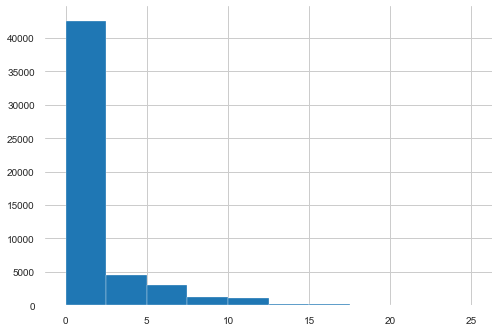

In [322]:
round(data.age_in_days/365).hist()

In [323]:
data[data.age_in_days > 9000]

age_upon_outcome animal_type     breed         color date_of_birth  \
45460          25 year        Bird  Cockatoo  White/Orange    1991-12-11   

            name outcome_subtype outcome_type sex_upon_outcome  \
45460  Sweet Pea         Partner     Transfer    Intact Female   

       num_of_returns max_datetime  age_dig age_metric  age_convert  \
45460               1   2016-12-16     25.0       year       9125.0   

       age_in_days  
45460         9137

Уберем птицу в возрасте 25 лет

In [324]:
data = data[data.age_in_days <= 9000]

In [325]:
data.describe()

num_of_returns      age_dig   age_convert   age_in_days
count    52798.000000  52796.00000  52796.000000  52798.000000
mean         1.072465      3.28523    587.519585    620.331641
std          0.295964      2.62273    886.620563    905.462937
min          1.000000      0.00000      0.000000   -123.000000
25%          1.000000      2.00000     60.000000     77.000000
50%          1.000000      2.00000    270.000000    295.000000
75%          1.000000      4.00000    730.000000    739.000000
max          6.000000     20.00000   7300.000000   7311.000000

In [326]:
data[data.age_in_days > 4800]

age_upon_outcome animal_type                     breed  \
114            15 year         Cat    Domestic Shorthair Mix   
180            16 year         Cat               Siamese Mix   
431            14 year         Dog                 Dachshund   
455            15 year         Cat    Domestic Shorthair Mix   
539            14 year         Cat    Domestic Shorthair Mix   
...                ...         ...                       ...   
55999          14 year         Dog   Chihuahua Shorthair Mix   
56220          15 year         Dog   Chihuahua Shorthair Mix   
56523          13 year         Cat            Abyssinian Mix   
56549          14 year         Dog              Shih Tzu Mix   
56585          15 year         Dog  Pembroke Welsh Corgi Mix   

                    color date_of_birth        name outcome_subtype  \
114            Blue Tabby    1999-05-06         NaN         Partner   
180            Lynx Point    1998-01-11      Laurel             NaN   
431             Red/White    2000-06-01     Winston         Partner   
455                Tortie    1999-10-18       Mitzy         Partner   
539          Orange Tabby    2000-10-18       Rusty         Partner   
...                   ...           ...         ...             ...   
55999                 Tan    2004-01-10        Lila             NaN   
56220         White/Brown    2003-01-03  Blanche D.             NaN   
56523  Brown Tabby/Agouti    2004-04-13       Jewel             NaN   
56549           White/Tan    2004-01-27         NaN         Partner   
56585         Brown/White    2002-07-13       Penny          Foster   

      outcome_type sex_upon_outcome  num_of_returns        max_datetime  \
114       Transfer    Intact Female               1 2014-05-14 15:30:00   
180       Adoption    Spayed Female               2 2014-02-12 18:34:00   
431       Transfer    Neutered Male               1 2014-06-03 12:26:00   
455       Transfer    Spayed Female               1 2014-10-22 15:08:00   
539       Transfer    Neutered Male               1 2014-10-22 15:08:00   
...            ...              ...             ...                 ...   
55999     Adoption    Spayed Female               2 2018-01-13 17:54:00   
56220     Adoption    Intact Female               1 2018-01-20 17:49:00   
56523     Adoption    Spayed Female               1 2018-01-28 17:51:00   
56549     Transfer    Neutered Male               1 2018-01-29 12:18:00   
56585     Adoption    Spayed Female               1 2018-02-01 13:18:00   

       age_dig age_metric  age_convert  age_in_days  
114       15.0       year       5475.0         5487  
180       16.0       year       5840.0         5876  
431       14.0       year       5110.0         5115  
455       15.0       year       5475.0         5483  
539       14.0       year       5110.0         5117  
...        ...        ...          ...          ...  
55999     14.0       year       5110.0         5117  
56220     15.0       year       5475.0         5496  
56523     13.0       year       4745.0         5038  
56549     14.0       year       5110.0         5116  
56585     15.0       year       5475.0         5682  

[243 rows x 15 columns]

In [327]:
data.shape

(52798, 15)

In [328]:
#  Кажется, мы можем убрать 243 строки, у которых возраст > 4800 (при том, что 0.995 квратиль равен 4769)

In [329]:
data = data[data.age_in_days <= 4800]

In [330]:
data.describe()

num_of_returns       age_dig   age_convert   age_in_days
count    52555.000000  52553.000000  52553.000000  52555.000000
mean         1.072438      3.232908    565.594048    598.156236
std          0.295957      2.511449    827.146317    846.051571
min          1.000000      0.000000      0.000000   -123.000000
25%          1.000000      2.000000     60.000000     77.000000
50%          1.000000      2.000000    270.000000    283.000000
75%          1.000000      4.000000    730.000000    738.000000
max          6.000000     13.000000   4745.000000   4800.000000

In [331]:
# Теперь посомтрим на отрицательное значение

In [332]:
data[data.age_in_days < 0]

age_upon_outcome animal_type                   breed         color  \
14128           0 year         Dog  Labrador Retriever Mix   Black/White   
36359           0 year         Cat  Domestic Shorthair Mix        Tortie   
38139           0 year         Cat  Domestic Shorthair Mix  Orange Tabby   

      date_of_birth   name outcome_subtype outcome_type sex_upon_outcome  \
14128    2014-04-03  Sadie         Partner     Transfer    Spayed Female   
36359    2015-07-06    NaN         Partner     Transfer          Unknown   
38139    2016-10-28    NaN         Partner     Transfer      Intact Male   

       num_of_returns        max_datetime  age_dig age_metric  age_convert  \
14128               1 2013-12-01 13:19:00      0.0       year          0.0   
36359               1 2015-07-05 14:46:00      0.0       year          0.0   
38139               1 2016-10-04 15:13:00      0.0       year          0.0   

       age_in_days  
14128         -123  
36359           -1  
38139          -24

In [333]:
# Таких всего три и их судьбу решили еще до их рождения - уберем

In [334]:
data = data[data.age_in_days >= 0 ]

In [335]:
data.describe()

num_of_returns       age_dig   age_convert   age_in_days
count    52552.000000  52550.000000  52550.000000  52552.000000
mean         1.072443      3.233092    565.626337    598.193199
std          0.295965      2.511402    827.158887    846.061481
min          1.000000      0.000000      0.000000      0.000000
25%          1.000000      2.000000     60.000000     77.000000
50%          1.000000      2.000000    270.000000    283.000000
75%          1.000000      4.000000    730.000000    738.000000
max          6.000000     13.000000   4745.000000   4800.000000

In [336]:
# Теперь можно делить

In [337]:
data.age_upon_outcome.value_counts()

1 year      8913
2 month     8385
2 year      6492
3 month     3090
1 month     2791
3 year      2730
4 month     2054
4 year      1477
5 month     1450
3 week      1392
5 year      1378
6 month     1349
2 week      1227
10 month     912
8 month      901
6 year       893
1 week       860
4 week       796
8 year       780
7 year       724
7 month      718
10 year      554
9 month      451
9 year       359
11 month     339
12 year      266
3 day        217
2 day        200
11 year      175
6 day        138
1 day        126
4 day        119
5 day         91
13 year       83
0 year        74
5 week        48
Name: age_upon_outcome, dtype: int64

Можно все дни и недели записать в 1 месяц, так как они все меньше месяца

In [338]:
data[data.age_metric == 'week']['age_dig'].unique()

array([2., 3., 4., 1., 5.])

In [339]:
data[data.age_upon_outcome == '5 week'].head()

age_upon_outcome animal_type                      breed         color  \
2323            5 week         Dog  Australian Cattle Dog Mix      Tricolor   
8274            5 week         Dog  Australian Cattle Dog Mix   Black/Brown   
10938           5 week         Dog  Australian Cattle Dog Mix      Tricolor   
12985           5 week         Cat   Domestic Medium Hair Mix  Orange Tabby   
15891           5 week         Cat       Domestic Medium Hair  Tortie/White   

      date_of_birth name outcome_subtype outcome_type sex_upon_outcome  \
2323     2014-05-20  NaN         Partner     Transfer    Intact Female   
8274     2014-05-20  NaN         Partner     Transfer    Intact Female   
10938    2014-05-20  NaN         Partner     Transfer    Intact Female   
12985    2014-05-15  NaN         Partner     Transfer      Intact Male   
15891    2014-06-18  NaN         Partner     Transfer    Intact Female   

       num_of_returns        max_datetime  age_dig age_metric  age_convert  \
2323                1 2014-06-24 16:34:00      5.0       week         35.0   
8274                1 2014-06-24 16:33:00      5.0       week         35.0   
10938               1 2014-06-24 16:34:00      5.0       week         35.0   
12985               1 2014-06-19 14:52:00      5.0       week         35.0   
15891               1 2014-07-23 14:39:00      5.0       week         35.0   

       age_in_days  
2323            35  
8274            35  
10938           35  
12985           35  
15891           35

In [340]:
data.groupby('age_upon_outcome')['age_in_days'].max()

age_upon_outcome
0 year         0
1 day          1
1 month       61
1 week        13
1 year       729
10 month     334
10 year     4008
11 month     364
11 year     4374
12 year     4738
13 year     4800
2 day          2
2 month       91
2 week        20
2 year      1094
3 day          3
3 month      121
3 week        27
3 year      1459
4 day          4
4 month      152
4 week        34
4 year      1824
5 day          5
5 month      182
5 week        35
5 year      2189
6 day          6
6 month      212
6 year      2554
7 month      243
7 year      2918
8 month      273
8 year      3280
9 month      304
9 year      3649
Name: age_in_days, dtype: int64

In [341]:
366*12

4392

In [342]:
# Первый вариант

In [343]:
# # bins = [0, 61, 123, 154, 185, 217, 247, 278, 309, 340, 371, 731, 1097, 1463, 1829, 2195, 2561, 2927, 3293, 3659\
#         , 4025\
#        ,4391, 4800]
# data['age_binned'] = pd.cut(data.age_in_days, bins)

In [344]:
# data.age_binned.value_counts()

In [87]:
# Второй вариант

In [345]:
# bins = [0, 61, 123, 154, 340, 371, 731, 1097, 1463, 1829, 2195, 4800]
# data['age_binned'] = pd.cut(data.age_in_days, bins, include_lowest=True)

In [346]:
# data.age_binned.value_counts()

In [347]:
# data['age_min'] = data.age_binned.apply(lambda x: x.left).astype(int)
# data['age_max'] = data.age_binned.apply(lambda x: x.right).astype(int)

In [348]:
# data.age_max.value_counts()

In [349]:
data['age_in_years'] = round(data.age_in_days/365)

In [350]:
data.age_in_years.value_counts()

0.0     23058
1.0     12322
2.0      7203
3.0      2957
4.0      1579
5.0      1426
6.0       911
8.0       774
7.0       767
10.0      562
9.0       407
12.0      261
11.0      200
13.0      125
Name: age_in_years, dtype: int64

In [351]:
# Мы все взяли из возраста - можно удалять ненужное

In [352]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52552 entries, 0 to 56610
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   age_upon_outcome  52552 non-null  object        
 1   animal_type       52552 non-null  object        
 2   breed             52552 non-null  object        
 3   color             52552 non-null  object        
 4   date_of_birth     52552 non-null  datetime64[ns]
 5   name              34805 non-null  object        
 6   outcome_subtype   28734 non-null  object        
 7   outcome_type      52552 non-null  object        
 8   sex_upon_outcome  52552 non-null  object        
 9   num_of_returns    52552 non-null  int64         
 10  max_datetime      52552 non-null  datetime64[ns]
 11  age_dig           52550 non-null  float64       
 12  age_metric        52550 non-null  object        
 13  age_convert       52550 non-null  float64       
 14  age_in_days       5255

In [353]:
data.drop(['age_upon_outcome', 'age_dig', 'age_metric', 'age_convert'], axis=1, inplace=True)

In [354]:
data.head()

animal_type                    breed         color date_of_birth     name  \
0         Cat   Domestic Shorthair Mix  Orange Tabby    2014-07-07      NaN   
1         Dog               Beagle Mix   White/Brown    2012-11-06     Lucy   
2         Dog                 Pit Bull    Blue/White    2013-03-31  *Johnny   
3         Dog  Miniature Schnauzer Mix         White    2005-06-02   Monday   
4         Dog           Leonberger Mix   Brown/White    2013-06-03   *Edgar   

  outcome_subtype outcome_type sex_upon_outcome  num_of_returns  \
0         Partner     Transfer      Intact Male               1   
1         Partner     Transfer    Spayed Female               1   
2             NaN     Adoption    Neutered Male               1   
3         Partner     Transfer    Neutered Male               1   
4         Partner     Transfer      Intact Male               1   

         max_datetime  age_in_days  age_in_years  
0 2014-07-22 16:04:00           15           0.0  
1 2013-11-07 11:47:00          366           1.0  
2 2014-06-03 14:20:00          429           1.0  
3 2014-06-15 15:50:00         3300           9.0  
4 2013-10-07 13:06:00          126           0.0

In [355]:
data.describe(include='all')

animal_type                   breed        color        date_of_birth  \
count        52552                   52552        52552                52552   
unique           5                    1803          474                 4695   
top            Dog  Domestic Shorthair Mix  Black/White  2014-05-05 00:00:00   
freq         26621                   19989         5627                   92   
first          NaN                     NaN          NaN  2000-10-21 00:00:00   
last           NaN                     NaN          NaN  2017-12-25 00:00:00   
mean           NaN                     NaN          NaN                  NaN   
std            NaN                     NaN          NaN                  NaN   
min            NaN                     NaN          NaN                  NaN   
25%            NaN                     NaN          NaN                  NaN   
50%            NaN                     NaN          NaN                  NaN   
75%            NaN                     NaN          NaN                  NaN   
max            NaN                     NaN          NaN                  NaN   

         name outcome_subtype outcome_type sex_upon_outcome  num_of_returns  \
count   34805           28734        52552            52552    52552.000000   
unique  11945               6            2                5             NaN   
top     Bella         Partner     Adoption    Neutered Male             NaN   
freq      172           19468        29408            18745             NaN   
first     NaN             NaN          NaN              NaN             NaN   
last      NaN             NaN          NaN              NaN             NaN   
mean      NaN             NaN          NaN              NaN        1.072443   
std       NaN             NaN          NaN              NaN        0.295965   
min       NaN             NaN          NaN              NaN        1.000000   
25%       NaN             NaN          NaN              NaN        1.000000   
50%       NaN             NaN          NaN              NaN        1.000000   
75%       NaN             NaN          NaN              NaN        1.000000   
max       NaN             NaN          NaN              NaN        6.000000   

               max_datetime   age_in_days  age_in_years  
count                 52552  52552.000000  52552.000000  
unique                41591           NaN           NaN  
top     2016-04-18 00:00:00           NaN           NaN  
freq                     39           NaN           NaN  
first   2013-10-01 09:31:00           NaN           NaN  
last    2018-02-01 18:44:00           NaN           NaN  
mean                    NaN    598.193199      1.566296  
std                     NaN    846.061481      2.356122  
min                     NaN      0.000000      0.000000  
25%                     NaN     77.000000      0.000000  
50%                     NaN    283.000000      1.000000  
75%                     NaN    738.000000      2.000000  
max                     NaN   4800.000000     13.000000

In [356]:
# Даты больше не нужны

In [357]:
data.drop(['date_of_birth', 'max_datetime'], axis=1, inplace=True)

In [358]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52552 entries, 0 to 56610
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   animal_type       52552 non-null  object 
 1   breed             52552 non-null  object 
 2   color             52552 non-null  object 
 3   name              34805 non-null  object 
 4   outcome_subtype   28734 non-null  object 
 5   outcome_type      52552 non-null  object 
 6   sex_upon_outcome  52552 non-null  object 
 7   num_of_returns    52552 non-null  int64  
 8   age_in_days       52552 non-null  int64  
 9   age_in_years      52552 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 4.4+ MB


### Убираю анализ пород - слишком много признаков

In [359]:
data.breed.value_counts()

Domestic Shorthair Mix                  19989
Chihuahua Shorthair Mix                  3165
Pit Bull Mix                             3079
Labrador Retriever Mix                   2947
Domestic Medium Hair Mix                 1962
                                        ...  
Blue Lacy/Black Mouth Cur                   1
Pomeranian/Cocker Spaniel                   1
Chow Chow/Pekingese                         1
Rhod Ridgeback/Australian Cattle Dog        1
Hovawart Mix                                1
Name: breed, Length: 1803, dtype: int64

In [360]:
data.breed.str.replace(' Mix', '').value_counts()

Domestic Shorthair                     20296
Chihuahua Shorthair                     3278
Pit Bull                                3173
Labrador Retriever                      3062
Domestic Medium Hair                    2080
                                       ...  
American Bulldog/Basset Hound              1
Rhode Island                               1
Cairn Terrier/Shih Tzu                     1
American Pit Bull Terrier/Catahoula        1
Dachshund/Border Collie                    1
Name: breed, Length: 1622, dtype: int64

In [361]:
# # Уберем MIX
# data['is_mix_in_breed'] = data.breed.apply(lambda x: 1 if ' Mix' in x else 0)
# data[data.is_mix_in_breed == 1].head()
# #Теперь уберем MIX
# data['breed'] = data.breed.str.replace(' Mix', '')

# data.breed.str.count(' ').sort_values()

# data.breed.str.count('/').sort_values()
# data['breed_1'], data['breed_2'] = data.breed.str.split('/', 1).str

# data.breed_2.value_counts()

# data[data.breed.str.contains('/')].head()
# data.breed_1.str.count(' ').sort_values()

# data.breed_1.str.split(' ', -1).str[-1]

# data['breed_1_type'] = data.breed_1.str.split(' ', -1).str[-1]
# data['breed_2_type'] = data.breed_2.str.split(' ', -1).str[-1]

# data.head()

# data.breed_1_type.value_counts()

# # Итак, мы разбили породы на 2 столбца (2 будет заполнен, если порода смешанная). Для 1 столбца (основного), мы выделили "семейство", итого получилось 220 уникальных значений. Уберем столбец breed, breed_1, breed_2, breed_2_type. Вместо этого у нас останется breed_1_type, а также сделаем доп.столбец с флагом - смешанная порода или нет.

# data['is_second_breed'] = data.breed_2.apply(lambda x: 1 if pd.notna(x) else 0)

# data[data.breed.str.contains('/')].head()
# data.drop(['breed', 'breed_1', 'breed_2', 'breed_2_type'], axis=1, inplace=True)

# breed_stat = pd.DataFrame(data.breed_1_type.value_counts())

# breed_stat.describe()

# breed_stat.head()

# breed_type_stat = data.groupby(['animal_type', 'breed_1_type'])['outcome_type'].count().reset_index()

# breed_type_stat[breed_type_stat.animal_type == 'Bird']

# pd.options.display.max_rows= 140
# breed_type_stat.sort_values(by=['animal_type', 'outcome_type'], ascending=False)

# breed_type_stat['rank_br'] = breed_type_stat.sort_values(['animal_type', 'outcome_type']\
#                                                , ascending=[True, False]) \
#              .groupby(['animal_type']) \
#              .cumcount() + 1

# breed_type_stat.sort_values(['animal_type', 'outcome_type']\
#                                                , ascending=[True, False])

# breed_type_stat[breed_type_stat.animal_type == 'Dog'].sort_values('rank_br').head(10)
# plt.figure(figsize=(20,10))
# data[data.animal_type == 'Dog']['breed_1_type'].value_counts().plot(kind='bar')

# data = data.merge(breed_type_stat, how='left', left_on=['animal_type', 'breed_1_type']\
#            , right_on=['animal_type', 'breed_1_type'])

# data['rank_br_top_3'] = data.rank_br_dig.apply(lambda x: 1 if x < 4 else 0)

# data.head()

# data.describe()

# len(data[data.rank_br < 40])/len(data)

# data.shape

# data.animal_type.value_counts()

# data[data.rank_br < 40].shape

# data[data.rank_br < 40].animal_type.value_counts()

# # Можно убрать редкие записи (rank_br < 40).

# data = data[data.rank_br < 40]
# data.shape

# data.breed_1_type.value_counts().head()

# data.head()

# data.columns = ['animal_type', 'color', 'name', 'outcome_subtype', 'outcome_type',
#        'sex_upon_outcome', 'num_of_returns', 'age_in_days', 'age_binned',
#        'age_min', 'age_max', 'age_in_years', 'is_mix_in_breed', 'breed_1_type',
#        'is_second_breed', 'breed_popularity', 'rank_br_dig', 'rank_br_top_3']

# data.head()

In [362]:
data.drop(['breed'], axis=1, inplace=True)

In [363]:
data.head()

animal_type         color     name outcome_subtype outcome_type  \
0         Cat  Orange Tabby      NaN         Partner     Transfer   
1         Dog   White/Brown     Lucy         Partner     Transfer   
2         Dog    Blue/White  *Johnny             NaN     Adoption   
3         Dog         White   Monday         Partner     Transfer   
4         Dog   Brown/White   *Edgar         Partner     Transfer   

  sex_upon_outcome  num_of_returns  age_in_days  age_in_years  
0      Intact Male               1           15           0.0  
1    Spayed Female               1          366           1.0  
2    Neutered Male               1          429           1.0  
3    Neutered Male               1         3300           9.0  
4      Intact Male               1          126           0.0

In [364]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52552 entries, 0 to 56610
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   animal_type       52552 non-null  object 
 1   color             52552 non-null  object 
 2   name              34805 non-null  object 
 3   outcome_subtype   28734 non-null  object 
 4   outcome_type      52552 non-null  object 
 5   sex_upon_outcome  52552 non-null  object 
 6   num_of_returns    52552 non-null  int64  
 7   age_in_days       52552 non-null  int64  
 8   age_in_years      52552 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 4.0+ MB


In [365]:
data.describe(include='all')

animal_type        color   name outcome_subtype outcome_type  \
count        52552        52552  34805           28734        52552   
unique           5          474  11945               6            2   
top            Dog  Black/White  Bella         Partner     Adoption   
freq         26621         5627    172           19468        29408   
mean           NaN          NaN    NaN             NaN          NaN   
std            NaN          NaN    NaN             NaN          NaN   
min            NaN          NaN    NaN             NaN          NaN   
25%            NaN          NaN    NaN             NaN          NaN   
50%            NaN          NaN    NaN             NaN          NaN   
75%            NaN          NaN    NaN             NaN          NaN   
max            NaN          NaN    NaN             NaN          NaN   

       sex_upon_outcome  num_of_returns   age_in_days  age_in_years  
count             52552    52552.000000  52552.000000  52552.000000  
unique                5             NaN           NaN           NaN  
top       Neutered Male             NaN           NaN           NaN  
freq              18745             NaN           NaN           NaN  
mean                NaN        1.072443    598.193199      1.566296  
std                 NaN        0.295965    846.061481      2.356122  
min                 NaN        1.000000      0.000000      0.000000  
25%                 NaN        1.000000     77.000000      0.000000  
50%                 NaN        1.000000    283.000000      1.000000  
75%                 NaN        1.000000    738.000000      2.000000  
max                 NaN        6.000000   4800.000000     13.000000

Теперь посмотрим на цвет:

In [366]:
data.color.value_counts()

Black/White               5627
Black                     4894
Brown Tabby               3828
Brown Tabby/White         1968
Orange Tabby              1830
                          ... 
Brown/Red Merle              1
Black Tabby/Gray Tabby       1
Calico/Orange Tabby          1
Blue Smoke/Gray              1
Chocolate/Yellow             1
Name: color, Length: 474, dtype: int64

In [367]:
data.color.str.count('/').sort_values()

0        0
31464    0
31462    0
31461    0
31455    0
        ..
33263    1
33262    1
11677    1
33276    1
56610    1
Name: color, Length: 52552, dtype: int64

In [368]:
data['color_1'], data['color_2'] = data.color.str.split('/').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [369]:
data.color_1.value_counts().head()

Black          12921
White           6301
Brown Tabby     5862
Brown           3470
Tan             3247
Name: color_1, dtype: int64

In [370]:
data.color_2.value_counts().head()

White    16858
Black     2907
Tan       2349
Brown     1925
Gray       294
Name: color_2, dtype: int64

In [371]:
data['color_1'], data['color_1_picture'] = data.color_1.str.split(' ', 1).str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [372]:
data['color_2'], data['color_2_picture'] = data.color_2.str.split(' ').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [373]:
data.head()

animal_type         color     name outcome_subtype outcome_type  \
0         Cat  Orange Tabby      NaN         Partner     Transfer   
1         Dog   White/Brown     Lucy         Partner     Transfer   
2         Dog    Blue/White  *Johnny             NaN     Adoption   
3         Dog         White   Monday         Partner     Transfer   
4         Dog   Brown/White   *Edgar         Partner     Transfer   

  sex_upon_outcome  num_of_returns  age_in_days  age_in_years color_1 color_2  \
0      Intact Male               1           15           0.0  Orange     NaN   
1    Spayed Female               1          366           1.0   White   Brown   
2    Neutered Male               1          429           1.0    Blue   White   
3    Neutered Male               1         3300           9.0   White     NaN   
4      Intact Male               1          126           0.0   Brown   White   

  color_1_picture color_2_picture  
0           Tabby             NaN  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN

In [374]:
# sum(
data.color_1.value_counts()
# .head(12)
# /len(data)

Black        13425
Brown        10716
White         6301
Blue          4370
Tan           3247
Orange        2881
Red           1351
Tricolor      1344
Tortie        1330
Calico        1283
Cream         1082
Torbie         909
Chocolate      771
Gray           634
Sable          533
Lynx           397
Yellow         397
Buff           352
Fawn           315
Seal           302
Flame          165
Silver         150
Gold            95
Lilac           71
Apricot         49
Green           33
Liver           23
Pink            15
Agouti          10
Ruddy            1
Name: color_1, dtype: int64

In [375]:
# color_dict = {'Black': 'Black', 'Brown':'Brown', 'White':'White', 'Blue':'Blue', 'Tan': 'Orange', 'Orange':'Orange'\
#             ,'Red':'Red', 'Tricolor':'Tricolor', 'Tortie':'Green', 'Calico':'Tricolor', 'Gray':'Gray', \
#             'Cream':'White','Chocolate':'Brown', 'Torbie':'Tricolor', 'Sable':'Black', 'Yellow':'Orange',\
#               'Fawn':'Orange', 'Buff':'Brown', 'Lynx':'Other', 'Seal':'Other', 'Silver':'Gray','Flame': 'Orange'\
#             ,'Gold':'Orange', 'Lilac':'Pink', 'Apricot':'Orange', 'Liver':'Other', 'Pink':'Pink', 'Green':'Green'\
#             ,'Agouti':'Gray', 'Ruddy':'Red'}

In [376]:
# data['color_1_gr'] = data.color_1.map(color_dict)
# data['color_2_gr'] = data.color_2.map(color_dict)

In [378]:
# data[(data.color_2_gr.isna())&(data.color_2.notna())]

In [379]:
data['is_color_with_picture'] = data.apply(lambda x: 0 if pd.isna(x['color_1_picture']) \
                                           and pd.isna(x['color_2_picture']) else 1, axis=1)

In [380]:
data.head()

animal_type         color     name outcome_subtype outcome_type  \
0         Cat  Orange Tabby      NaN         Partner     Transfer   
1         Dog   White/Brown     Lucy         Partner     Transfer   
2         Dog    Blue/White  *Johnny             NaN     Adoption   
3         Dog         White   Monday         Partner     Transfer   
4         Dog   Brown/White   *Edgar         Partner     Transfer   

  sex_upon_outcome  num_of_returns  age_in_days  age_in_years color_1 color_2  \
0      Intact Male               1           15           0.0  Orange     NaN   
1    Spayed Female               1          366           1.0   White   Brown   
2    Neutered Male               1          429           1.0    Blue   White   
3    Neutered Male               1         3300           9.0   White     NaN   
4      Intact Male               1          126           0.0   Brown   White   

  color_1_picture color_2_picture  is_color_with_picture  
0           Tabby             NaN                      1  
1             NaN             NaN                      0  
2             NaN             NaN                      0  
3             NaN             NaN                      0  
4             NaN             NaN                      0

In [381]:
data[data.color_2.isna()]

animal_type         color     name outcome_subtype outcome_type  \
0             Cat  Orange Tabby      NaN         Partner     Transfer   
3             Dog         White   Monday         Partner     Transfer   
5             Dog         Brown    *Ella         Partner     Transfer   
9             Dog         Black     Kash          Foster     Adoption   
16            Cat   Black Tabby  Chester             NaN     Adoption   
...           ...           ...      ...             ...          ...   
56597         Cat  Orange Tabby      Mac             NaN     Adoption   
56599         Dog         White   Bailey          Foster     Adoption   
56602         Dog         Brown      NaN             NaN     Adoption   
56604         Dog         White      NaN          Foster     Adoption   
56609         Dog           Red      NaN             NaN     Adoption   

      sex_upon_outcome  num_of_returns  age_in_days  age_in_years color_1  \
0          Intact Male               1           15           0.0  Orange   
3        Neutered Male               1         3300           9.0   White   
5        Spayed Female               1         1111           3.0   Brown   
9        Neutered Male               1           80           0.0   Black   
16       Neutered Male               1          162           0.0   Black   
...                ...             ...          ...           ...     ...   
56597    Neutered Male               1          188           1.0  Orange   
56599    Spayed Female               1           59           0.0   White   
56602    Neutered Male               1           80           0.0   Brown   
56604    Spayed Female               1           59           0.0   White   
56609    Spayed Female               1           80           0.0     Red   

      color_2 color_1_picture color_2_picture  is_color_with_picture  
0         NaN           Tabby             NaN                      1  
3         NaN             NaN             NaN                      0  
5         NaN             NaN             NaN                      0  
9         NaN             NaN             NaN                      0  
16        NaN           Tabby             NaN                      1  
...       ...             ...             ...                    ...  
56597     NaN           Tabby             NaN                      1  
56599     NaN             NaN             NaN                      0  
56602     NaN             NaN             NaN                      0  
56604     NaN             NaN             NaN                      0  
56609     NaN             NaN             NaN                      0  

[26118 rows x 14 columns]

In [382]:
# data['is_double_color'] = data.color_2.apply(lambda x: 0 if pd.isna(x) else 1)

In [383]:
data.head()

animal_type         color     name outcome_subtype outcome_type  \
0         Cat  Orange Tabby      NaN         Partner     Transfer   
1         Dog   White/Brown     Lucy         Partner     Transfer   
2         Dog    Blue/White  *Johnny             NaN     Adoption   
3         Dog         White   Monday         Partner     Transfer   
4         Dog   Brown/White   *Edgar         Partner     Transfer   

  sex_upon_outcome  num_of_returns  age_in_days  age_in_years color_1 color_2  \
0      Intact Male               1           15           0.0  Orange     NaN   
1    Spayed Female               1          366           1.0   White   Brown   
2    Neutered Male               1          429           1.0    Blue   White   
3    Neutered Male               1         3300           9.0   White     NaN   
4      Intact Male               1          126           0.0   Brown   White   

  color_1_picture color_2_picture  is_color_with_picture  
0           Tabby             NaN                      1  
1             NaN             NaN                      0  
2             NaN             NaN                      0  
3             NaN             NaN                      0  
4             NaN             NaN                      0

In [384]:
data.drop(['color', 'color_2', 'color_1_picture', 'color_2_picture', 'is_color_with_picture']\
          , axis=1, inplace=True)

In [385]:
data.head()

animal_type     name outcome_subtype outcome_type sex_upon_outcome  \
0         Cat      NaN         Partner     Transfer      Intact Male   
1         Dog     Lucy         Partner     Transfer    Spayed Female   
2         Dog  *Johnny             NaN     Adoption    Neutered Male   
3         Dog   Monday         Partner     Transfer    Neutered Male   
4         Dog   *Edgar         Partner     Transfer      Intact Male   

   num_of_returns  age_in_days  age_in_years color_1  
0               1           15           0.0  Orange  
1               1          366           1.0   White  
2               1          429           1.0    Blue  
3               1         3300           9.0   White  
4               1          126           0.0   Brown

In [390]:
sum(data.color_1.value_counts().head(15))/len(data)

0.9548066676815344

In [391]:
list_of_top_colors = data.color_1.value_counts().head(15).index
list_of_top_colors

Index(['Black', 'Brown', 'White', 'Blue', 'Tan', 'Orange', 'Red', 'Tricolor',
       'Tortie', 'Calico', 'Cream', 'Torbie', 'Chocolate', 'Gray', 'Sable'],
      dtype='object')

In [393]:
data['color_1'] = data.color_1.apply(lambda x: x if x in list_of_top_colors\
                                          else 'Other color')

In [394]:
data.head()

animal_type     name outcome_subtype outcome_type sex_upon_outcome  \
0         Cat      NaN         Partner     Transfer      Intact Male   
1         Dog     Lucy         Partner     Transfer    Spayed Female   
2         Dog  *Johnny             NaN     Adoption    Neutered Male   
3         Dog   Monday         Partner     Transfer    Neutered Male   
4         Dog   *Edgar         Partner     Transfer      Intact Male   

   num_of_returns  age_in_days  age_in_years color_1  
0               1           15           0.0  Orange  
1               1          366           1.0   White  
2               1          429           1.0    Blue  
3               1         3300           9.0   White  
4               1          126           0.0   Brown

Name

In [395]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52552 entries, 0 to 56610
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   animal_type       52552 non-null  object 
 1   name              34805 non-null  object 
 2   outcome_subtype   28734 non-null  object 
 3   outcome_type      52552 non-null  object 
 4   sex_upon_outcome  52552 non-null  object 
 5   num_of_returns    52552 non-null  int64  
 6   age_in_days       52552 non-null  int64  
 7   age_in_years      52552 non-null  float64
 8   color_1           52552 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 4.0+ MB


Осталось два поля с пустыми значениями - name и outcome_subtype.
Кажется, что name не может влиять на решение о приюте животного, но пока оставим ради интереса, заменим только на какое-нибудь значение, типо Unknown
А outcome_subtype посмотрим поподробнее, но скорее всего уберем его вообще, так как значение может напрямую указывать на outcome_type

In [396]:
data.name.value_counts()

Bella          172
Luna           136
Max            136
Daisy          129
Lucy           114
              ... 
*Dalhausser      1
*Nelda           1
*Mylo            1
*Marvel          1
Remmy            1
Name: name, Length: 11945, dtype: int64

In [397]:
data_with_special_name = data[(data.name.fillna(' ').str.contains('^\W', regex=True))&(data.name.notna())]

Не понятно, зачем нужен символ * перед именем животного

In [398]:
data_with_special_name.animal_type.value_counts()

Cat      8299
Dog      8292
Other     164
Bird        7
Name: animal_type, dtype: int64

In [399]:
data_with_special_name.outcome_type.value_counts()

Adoption    11119
Transfer     5643
Name: outcome_type, dtype: int64

In [400]:
data_with_special_name.outcome_subtype.value_counts()

Partner    5562
Foster     3032
Offsite     180
SCRP         67
Snr          14
Name: outcome_subtype, dtype: int64

In [401]:
data_with_special_name.sex_upon_outcome.value_counts()

Neutered Male    7227
Spayed Female    6869
Intact Female    1417
Intact Male      1200
Unknown            49
Name: sex_upon_outcome, dtype: int64

Значения такие же как и в основном датасете, просто уберу эту звездочку, возможно, в приюте не знают точного имени и/или назвали сами. Но создам пока столбец с флагом - имя было со звездочкой или без

In [402]:
data['name'] = data.name.str.replace('*', 'SPECIAL_CH_TO_REMOVE')

In [403]:
data['is_special_name'] = np.where(data.name.str.contains('SPECIAL_CH_TO_REMOVE'), 1, 0)
data['is_special_name'] = np.where(data.name.isna(), 0, data.is_special_name)

In [404]:
data.head()

animal_type                        name outcome_subtype outcome_type  \
0         Cat                         NaN         Partner     Transfer   
1         Dog                        Lucy         Partner     Transfer   
2         Dog  SPECIAL_CH_TO_REMOVEJohnny             NaN     Adoption   
3         Dog                      Monday         Partner     Transfer   
4         Dog   SPECIAL_CH_TO_REMOVEEdgar         Partner     Transfer   

  sex_upon_outcome  num_of_returns  age_in_days  age_in_years color_1  \
0      Intact Male               1           15           0.0  Orange   
1    Spayed Female               1          366           1.0   White   
2    Neutered Male               1          429           1.0    Blue   
3    Neutered Male               1         3300           9.0   White   
4      Intact Male               1          126           0.0   Brown   

   is_special_name  
0                0  
1                0  
2                1  
3                0  
4                1

In [405]:
data['name'] = data.name.str.replace('SPECIAL_CH_TO_REMOVE', '')

In [406]:
data.head()

animal_type    name outcome_subtype outcome_type sex_upon_outcome  \
0         Cat     NaN         Partner     Transfer      Intact Male   
1         Dog    Lucy         Partner     Transfer    Spayed Female   
2         Dog  Johnny             NaN     Adoption    Neutered Male   
3         Dog  Monday         Partner     Transfer    Neutered Male   
4         Dog   Edgar         Partner     Transfer      Intact Male   

   num_of_returns  age_in_days  age_in_years color_1  is_special_name  
0               1           15           0.0  Orange                0  
1               1          366           1.0   White                0  
2               1          429           1.0    Blue                1  
3               1         3300           9.0   White                0  
4               1          126           0.0   Brown                1

Создам еще столбец - из скольких слов состоит имя животного, если пустота - 0 + столбец с кол-вом букв в имени

In [407]:
data['name_num_of_letters'] = data.name.str.replace(' ', '').str.split('').str.len().fillna(0).astype('int')

In [408]:
# data['name_num_of_words'] = data.name.str.split(' ').str.len().fillna(0).astype('int')

In [409]:
data.head()

animal_type    name outcome_subtype outcome_type sex_upon_outcome  \
0         Cat     NaN         Partner     Transfer      Intact Male   
1         Dog    Lucy         Partner     Transfer    Spayed Female   
2         Dog  Johnny             NaN     Adoption    Neutered Male   
3         Dog  Monday         Partner     Transfer    Neutered Male   
4         Dog   Edgar         Partner     Transfer      Intact Male   

   num_of_returns  age_in_days  age_in_years color_1  is_special_name  \
0               1           15           0.0  Orange                0   
1               1          366           1.0   White                0   
2               1          429           1.0    Blue                1   
3               1         3300           9.0   White                0   
4               1          126           0.0   Brown                1   

   name_num_of_letters  
0                    0  
1                    6  
2                    8  
3                    8  
4                    7

In [410]:
# data.name_num_of_words.value_counts()

In [411]:
data['name'] = data.name.fillna('No name')

In [412]:
name_stat = data.name.value_counts().reset_index()

In [413]:
name_stat.reset_index(inplace=True)

In [154]:
name_stat.columns = ['rank_name', 'name', 'num_of_records']
name_stat

rank_name     name  num_of_records
0             0  No name           17747
1             1    Bella             194
2             2  Charlie             187
3             3      Max             178
4             4    Daisy             175
...         ...      ...             ...
9543       9543       Cy               1
9544       9544  Swanson               1
9545       9545    Monet               1
9546       9546   Oracle               1
9547       9547    Remmy               1

[9548 rows x 3 columns]

In [414]:
# data = data.merge(name_stat, how='left', left_on='name', right_on='name')

In [415]:
# data['rank_name_top_10'] = data.rank_name.apply(lambda x: 1 if x < 11 else 0)

In [416]:
data.head()

animal_type     name outcome_subtype outcome_type sex_upon_outcome  \
0         Cat  No name         Partner     Transfer      Intact Male   
1         Dog     Lucy         Partner     Transfer    Spayed Female   
2         Dog   Johnny             NaN     Adoption    Neutered Male   
3         Dog   Monday         Partner     Transfer    Neutered Male   
4         Dog    Edgar         Partner     Transfer      Intact Male   

   num_of_returns  age_in_days  age_in_years color_1  is_special_name  \
0               1           15           0.0  Orange                0   
1               1          366           1.0   White                0   
2               1          429           1.0    Blue                1   
3               1         3300           9.0   White                0   
4               1          126           0.0   Brown                1   

   name_num_of_letters  
0                    0  
1                    6  
2                    8  
3                    8  
4                    7

In [417]:
data.drop(['name'], axis=1, inplace=True)

In [418]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52552 entries, 0 to 56610
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   animal_type          52552 non-null  object 
 1   outcome_subtype      28734 non-null  object 
 2   outcome_type         52552 non-null  object 
 3   sex_upon_outcome     52552 non-null  object 
 4   num_of_returns       52552 non-null  int64  
 5   age_in_days          52552 non-null  int64  
 6   age_in_years         52552 non-null  float64
 7   color_1              52552 non-null  object 
 8   is_special_name      52552 non-null  int64  
 9   name_num_of_letters  52552 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 4.4+ MB


In [419]:
data.describe(include='all')

animal_type outcome_subtype outcome_type sex_upon_outcome  \
count        52552           28734        52552            52552   
unique           5               6            2                5   
top            Dog         Partner     Adoption    Neutered Male   
freq         26621           19468        29408            18745   
mean           NaN             NaN          NaN              NaN   
std            NaN             NaN          NaN              NaN   
min            NaN             NaN          NaN              NaN   
25%            NaN             NaN          NaN              NaN   
50%            NaN             NaN          NaN              NaN   
75%            NaN             NaN          NaN              NaN   
max            NaN             NaN          NaN              NaN   

        num_of_returns   age_in_days  age_in_years color_1  is_special_name  \
count     52552.000000  52552.000000  52552.000000   52552     52552.000000   
unique             NaN           NaN           NaN      16              NaN   
top                NaN           NaN           NaN   Black              NaN   
freq               NaN           NaN           NaN   13425              NaN   
mean          1.072443    598.193199      1.566296     NaN         0.318979   
std           0.295965    846.061481      2.356122     NaN         0.466085   
min           1.000000      0.000000      0.000000     NaN         0.000000   
25%           1.000000     77.000000      0.000000     NaN         0.000000   
50%           1.000000    283.000000      1.000000     NaN         0.000000   
75%           1.000000    738.000000      2.000000     NaN         1.000000   
max           6.000000   4800.000000     13.000000     NaN         1.000000   

        name_num_of_letters  
count          52552.000000  
unique                  NaN  
top                     NaN  
freq                    NaN  
mean               5.024890  
std                3.816721  
min                0.000000  
25%                0.000000  
50%                6.000000  
75%                8.000000  
max               14.000000

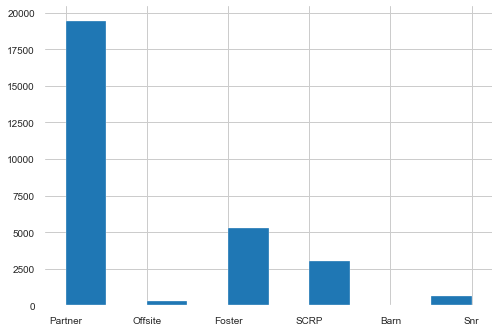

In [420]:
data.outcome_subtype.hist()

In [421]:
data.outcome_subtype.value_counts()

Partner    19468
Foster      5261
SCRP        3060
Snr          614
Offsite      328
Barn           3
Name: outcome_subtype, dtype: int64

Barn встречается крайне редко - уберем эти значения

In [422]:
data = data[data.outcome_subtype != 'Barn']

Теперь посмотрим зависмость outcome_subtype и outcome_type

In [423]:
data.groupby('outcome_type')['outcome_subtype'].nunique()

outcome_type
Adoption    2
Transfer    3
Name: outcome_subtype, dtype: int64

In [424]:
data.groupby('outcome_subtype')['outcome_type'].nunique()

outcome_subtype
Foster     1
Offsite    1
Partner    1
SCRP       1
Snr        1
Name: outcome_type, dtype: int64

In [425]:
data.groupby(['outcome_subtype', 'outcome_type'])['animal_type'].count()

outcome_subtype  outcome_type
Foster           Adoption         5261
Offsite          Adoption          328
Partner          Transfer        19468
SCRP             Transfer         3060
Snr              Transfer          614
Name: animal_type, dtype: int64

Чаще всего outcome_subtype указывает на конкретный outcome_type (кол-во уникальных outcome_type = 1)

In [426]:
data.profile_report()

Profiler подтвердил, что subtype сильно коррелирует с type - на мой взгляд, нужно убирать этот столбец

In [427]:
data.drop(['outcome_subtype'], axis=1, inplace=True)

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [428]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52549 entries, 0 to 56610
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   animal_type          52549 non-null  object 
 1   outcome_type         52549 non-null  object 
 2   sex_upon_outcome     52549 non-null  object 
 3   num_of_returns       52549 non-null  int64  
 4   age_in_days          52549 non-null  int64  
 5   age_in_years         52549 non-null  float64
 6   color_1              52549 non-null  object 
 7   is_special_name      52549 non-null  int64  
 8   name_num_of_letters  52549 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 4.0+ MB


Почистили все пустые значения и заодно сделали некоторые преобразования.

In [429]:
data.head()

animal_type outcome_type sex_upon_outcome  num_of_returns  age_in_days  \
0         Cat     Transfer      Intact Male               1           15   
1         Dog     Transfer    Spayed Female               1          366   
2         Dog     Adoption    Neutered Male               1          429   
3         Dog     Transfer    Neutered Male               1         3300   
4         Dog     Transfer      Intact Male               1          126   

   age_in_years color_1  is_special_name  name_num_of_letters  
0           0.0  Orange                0                    0  
1           1.0   White                0                    6  
2           1.0    Blue                1                    8  
3           9.0   White                0                    8  
4           0.0   Brown                1                    7

In [430]:
data.animal_type.value_counts()

Dog          26620
Cat          24952
Other          766
Bird           203
Livestock        8
Name: animal_type, dtype: int64

Очень редко встречаются не собаки и не кошки - объединим их в одну группу

In [431]:
data['animal_type'] = data.animal_type.apply(lambda x: x if x== 'Dog' or x=='Cat' else 'Other_animal_type' )

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [432]:
data.animal_type.value_counts()

Dog                  26620
Cat                  24952
Other_animal_type      977
Name: animal_type, dtype: int64

In [433]:
data.sex_upon_outcome.value_counts()

Neutered Male    18743
Spayed Female    18046
Intact Female     6781
Intact Male       6222
Unknown           2757
Name: sex_upon_outcome, dtype: int64

In [434]:
data['sterilized'], data['gender'] = data['sex_upon_outcome'].str.split(' ').str

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.
/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [435]:
data.sterilized.value_counts()

Neutered    18743
Spayed      18046
Intact      13003
Unknown      2757
Name: sterilized, dtype: int64

In [436]:
data.gender.value_counts()

Male      24965
Female    24827
Name: gender, dtype: int64

Заметила, что Neutered и Spayed это по сути одно и тоже, просто одно для мальчиков, другое для девочек - объединим это в один признак -  sterilized


In [437]:
data['sterilized'] = data.sterilized.apply(lambda x: 'Sterilized' if x == 'Neutered' or x == 'Spayed'\
                                           else x)

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [438]:
data.sterilized.value_counts()

Sterilized    36789
Intact        13003
Unknown        2757
Name: sterilized, dtype: int64

Sterilized и Intact являются одним и тем же признаком, просто с разных сторон, к тому же если неизвестно стерилизлван или нет, то тут примерно такие же ожидания как и от Intact. Поэтому объединим Intact и Unknown в один признак.

In [439]:
data['sterilized'] = data.sterilized.apply(lambda x: 1 if x == 'Sterilized' else 0)

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [440]:
# data.drop(['sex_upon_outcome'], axis=1, inplace=True)

In [441]:
pd.options.display.max_columns= 30
data.describe(include='all')

animal_type outcome_type sex_upon_outcome  num_of_returns  \
count        52549        52549            52549    52549.000000   
unique           3            2                5             NaN   
top            Dog     Adoption    Neutered Male             NaN   
freq         26620        29407            18743             NaN   
mean           NaN          NaN              NaN        1.072447   
std            NaN          NaN              NaN        0.295973   
min            NaN          NaN              NaN        1.000000   
25%            NaN          NaN              NaN        1.000000   
50%            NaN          NaN              NaN        1.000000   
75%            NaN          NaN              NaN        1.000000   
max            NaN          NaN              NaN        6.000000   

         age_in_days  age_in_years color_1  is_special_name  \
count   52549.000000  52549.000000   52549     52549.000000   
unique           NaN           NaN      16              NaN   
top              NaN           NaN   Black              NaN   
freq             NaN           NaN   13424              NaN   
mean      598.157225      1.566195     NaN         0.318998   
std       846.071183      2.356149     NaN         0.466093   
min         0.000000      0.000000     NaN         0.000000   
25%        77.000000      0.000000     NaN         0.000000   
50%       283.000000      1.000000     NaN         0.000000   
75%       738.000000      2.000000     NaN         1.000000   
max      4800.000000     13.000000     NaN         1.000000   

        name_num_of_letters    sterilized gender  
count          52549.000000  52549.000000  49792  
unique                  NaN           NaN      2  
top                     NaN           NaN   Male  
freq                    NaN           NaN  24965  
mean               5.024891      0.700089    NaN  
std                3.816736      0.458223    NaN  
min                0.000000      0.000000    NaN  
25%                0.000000      0.000000    NaN  
50%                6.000000      1.000000    NaN  
75%                8.000000      1.000000    NaN  
max               14.000000      1.000000    NaN

Что мне не нравится:
1. animal_type - Other_animal_type очень редко встречается, можно убрать
2. num_of_returns - макс значение и 75 квантиль очень отличаются
3. is_second_breed - 1-ца встречается редко
4. name_num_of_words - имя с 3 словами очень редко
5. сильные зависимости - 'age_in_days', 'age_binned', 'age_min', 'age_max', 'age_in_years' | будем брать только стобец из этих
6. сильные зависимости - 'name_num_of_letters', 'name_num_of_words', 'num_of_records', rank_name_top_10 | будем брать только стобец из этих

In [442]:
data.columns

Index(['animal_type', 'outcome_type', 'sex_upon_outcome', 'num_of_returns',
       'age_in_days', 'age_in_years', 'color_1', 'is_special_name',
       'name_num_of_letters', 'sterilized', 'gender'],
      dtype='object')

In [443]:
data_full = pd.DataFrame(data)

In [444]:
# data = pd.DataFrame(data_full)

In [445]:
data.animal_type.value_counts()

Dog                  26620
Cat                  24952
Other_animal_type      977
Name: animal_type, dtype: int64

In [446]:
data = data[data.animal_type != 'Other_animal_type']

In [447]:
data.describe(include='all')

animal_type outcome_type sex_upon_outcome  num_of_returns  \
count        51572        51572            51572    51572.000000   
unique           2            2                5             NaN   
top            Dog     Adoption    Neutered Male             NaN   
freq         26620        29086            18659             NaN   
mean           NaN          NaN              NaN        1.073703   
std            NaN          NaN              NaN        0.298427   
min            NaN          NaN              NaN        1.000000   
25%            NaN          NaN              NaN        1.000000   
50%            NaN          NaN              NaN        1.000000   
75%            NaN          NaN              NaN        1.000000   
max            NaN          NaN              NaN        6.000000   

         age_in_days  age_in_years color_1  is_special_name  \
count   51572.000000  51572.000000   51572     51572.000000   
unique           NaN           NaN      16              NaN   
top              NaN           NaN   Black              NaN   
freq             NaN           NaN   13228              NaN   
mean      601.241875      1.573237     NaN         0.321725   
std       851.795420      2.372409     NaN         0.467143   
min         0.000000      0.000000     NaN         0.000000   
25%        76.000000      0.000000     NaN         0.000000   
50%       277.000000      1.000000     NaN         0.000000   
75%       739.000000      2.000000     NaN         1.000000   
max      4800.000000     13.000000     NaN         1.000000   

        name_num_of_letters   sterilized gender  
count          51572.000000  51572.00000  49208  
unique                  NaN          NaN      2  
top                     NaN          NaN   Male  
freq                    NaN          NaN  24632  
mean               5.049368      0.71023    NaN  
std                3.804786      0.45366    NaN  
min                0.000000      0.00000    NaN  
25%                0.000000      0.00000    NaN  
50%                7.000000      1.00000    NaN  
75%                8.000000      1.00000    NaN  
max               14.000000      1.00000    NaN

In [448]:
data[data.num_of_returns > 2].shape

(403, 11)

In [449]:
data.shape

(51572, 11)

In [450]:
data = data[data.num_of_returns <= 2]

In [451]:
data.describe(include='all')

animal_type outcome_type sex_upon_outcome  num_of_returns  \
count        51169        51169            51169    51169.000000   
unique           2            2                5             NaN   
top            Dog     Adoption    Neutered Male             NaN   
freq         26288        28785            18466             NaN   
mean           NaN          NaN              NaN        1.057320   
std            NaN          NaN              NaN        0.232455   
min            NaN          NaN              NaN        1.000000   
25%            NaN          NaN              NaN        1.000000   
50%            NaN          NaN              NaN        1.000000   
75%            NaN          NaN              NaN        1.000000   
max            NaN          NaN              NaN        2.000000   

         age_in_days  age_in_years color_1  is_special_name  \
count   51169.000000  51169.000000   51169     51169.000000   
unique           NaN           NaN      16              NaN   
top              NaN           NaN   Black              NaN   
freq             NaN           NaN   13131              NaN   
mean      597.531513      1.562743     NaN         0.322578   
std       850.541716      2.369024     NaN         0.467467   
min         0.000000      0.000000     NaN         0.000000   
25%        76.000000      0.000000     NaN         0.000000   
50%       263.000000      1.000000     NaN         0.000000   
75%       738.000000      2.000000     NaN         1.000000   
max      4800.000000     13.000000     NaN         1.000000   

        name_num_of_letters    sterilized gender  
count          51169.000000  51169.000000  48805  
unique                  NaN           NaN      2  
top                     NaN           NaN   Male  
freq                    NaN           NaN  24439  
mean               5.032520      0.707968    NaN  
std                3.811775      0.454702    NaN  
min                0.000000      0.000000    NaN  
25%                0.000000      0.000000    NaN  
50%                6.000000      1.000000    NaN  
75%                8.000000      1.000000    NaN  
max               14.000000      1.000000    NaN

In [452]:
# data.is_second_breed.value_counts()

In [454]:
data.name_num_of_letters.value_counts()

0     17215
7      9777
8      7899
6      6493
9      3947
10     2098
5      1748
11     1046
12      456
13      244
4       131
14       60
3        53
2         2
Name: name_num_of_letters, dtype: int64

In [458]:
data = data[~data.name_num_of_letters.isin([2,3,14,4])]

In [459]:
data.describe(include='all')

animal_type outcome_type sex_upon_outcome  num_of_returns  \
count        50923        50923            50923    50923.000000   
unique           2            2                5             NaN   
top            Dog     Adoption    Neutered Male             NaN   
freq         26160        28640            18334             NaN   
mean           NaN          NaN              NaN        1.057243   
std            NaN          NaN              NaN        0.232309   
min            NaN          NaN              NaN        1.000000   
25%            NaN          NaN              NaN        1.000000   
50%            NaN          NaN              NaN        1.000000   
75%            NaN          NaN              NaN        1.000000   
max            NaN          NaN              NaN        2.000000   

         age_in_days  age_in_years color_1  is_special_name  \
count   50923.000000  50923.000000   50923     50923.000000   
unique           NaN           NaN      16              NaN   
top              NaN           NaN   Black              NaN   
freq             NaN           NaN   13058              NaN   
mean      596.495709      1.559826     NaN         0.323351   
std       849.645072      2.366553     NaN         0.467760   
min         0.000000      0.000000     NaN         0.000000   
25%        76.000000      0.000000     NaN         0.000000   
50%       261.000000      1.000000     NaN         0.000000   
75%       738.000000      2.000000     NaN         1.000000   
max      4800.000000     13.000000     NaN         1.000000   

        name_num_of_letters    sterilized  gender  
count          50923.000000  50923.000000   48561  
unique                  NaN           NaN       2  
top                     NaN           NaN  Female  
freq                    NaN           NaN   24282  
mean               5.026844      0.707460     NaN  
std                3.807575      0.454933     NaN  
min                0.000000      0.000000     NaN  
25%                0.000000      0.000000     NaN  
50%                7.000000      1.000000     NaN  
75%                8.000000      1.000000     NaN  
max               13.000000      1.000000     NaN

In [460]:
# data[data.rank_name > 2000].shape

In [461]:
# plt.figure(figsize=(20,10))
# data[data.rank_name != 0].rank_name.hist(bins=30)

In [462]:
# data[data.rank_name > 8000].shape

In [463]:
data.columns

Index(['animal_type', 'outcome_type', 'sex_upon_outcome', 'num_of_returns',
       'age_in_days', 'age_in_years', 'color_1', 'is_special_name',
       'name_num_of_letters', 'sterilized', 'gender'],
      dtype='object')

In [464]:
# data.columns = ['animal_type', 'outcome_type', 'num_of_returns', 'HC1_age_in_days',
#        'HC1_age_binned', 'HC1_age_min', 'HC1_age_max', 'HC1_age_in_years',
#        'color_1_gr', 'is_color_with_picture',
#        'is_double_color', 'is_special_name', 'HC2_name_num_of_letters',
#        'HC2_name_num_of_words', 'rank_name', 'HC2_num_of_records', 'HC2_rank_name_top_10',
#        'sterilized', 'gender']

In [465]:
data.head()

animal_type outcome_type sex_upon_outcome  num_of_returns  age_in_days  \
0         Cat     Transfer      Intact Male               1           15   
1         Dog     Transfer    Spayed Female               1          366   
2         Dog     Adoption    Neutered Male               1          429   
3         Dog     Transfer    Neutered Male               1         3300   
4         Dog     Transfer      Intact Male               1          126   

   age_in_years color_1  is_special_name  name_num_of_letters  sterilized  \
0           0.0  Orange                0                    0           0   
1           1.0   White                0                    6           1   
2           1.0    Blue                1                    8           1   
3           9.0   White                0                    8           1   
4           0.0   Brown                1                    7           0   

   gender  
0    Male  
1  Female  
2    Male  
3    Male  
4    Male

In [466]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50923 entries, 0 to 56610
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   animal_type          50923 non-null  object 
 1   outcome_type         50923 non-null  object 
 2   sex_upon_outcome     50923 non-null  object 
 3   num_of_returns       50923 non-null  int64  
 4   age_in_days          50923 non-null  int64  
 5   age_in_years         50923 non-null  float64
 6   color_1              50923 non-null  object 
 7   is_special_name      50923 non-null  int64  
 8   name_num_of_letters  50923 non-null  int64  
 9   sterilized           50923 non-null  int64  
 10  gender               48561 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 4.7+ MB


In [467]:
data.gender.value_counts()

Female    24282
Male      24279
Name: gender, dtype: int64

In [468]:
data[data.gender.isna()].shape

(2362, 11)

In [469]:
data['gender'] = data.gender.fillna('No gender info')

In [470]:
data.drop_duplicates().shape

(37368, 11)

In [471]:
data.drop_duplicates(inplace=True)

In [472]:
# data.drop(['HC1_age_binned'], axis=1, inplace=True)

In [473]:
data.reset_index(drop=True, inplace=True)

In [474]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   animal_type          37368 non-null  object 
 1   outcome_type         37368 non-null  object 
 2   sex_upon_outcome     37368 non-null  object 
 3   num_of_returns       37368 non-null  int64  
 4   age_in_days          37368 non-null  int64  
 5   age_in_years         37368 non-null  float64
 6   color_1              37368 non-null  object 
 7   is_special_name      37368 non-null  int64  
 8   name_num_of_letters  37368 non-null  int64  
 9   sterilized           37368 non-null  int64  
 10  gender               37368 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 3.1+ MB


In [482]:
cat_col = ['animal_type', 'outcome_type', 'sex_upon_outcome', 'color_1', 'gender']

In [476]:
# dig_col = list(set(data.columns) - set(cat_col))

In [477]:
ohe = OneHotEncoder()
le = LabelEncoder()

In [478]:
def onehot_df(col_name):
    col_name_ohe = ohe.fit_transform(data[[col_name]]).toarray()
    col_name_columns = ohe.categories_[0]
    col_name_df = pd.DataFrame(col_name_ohe, columns=col_name_columns)
    return col_name_df

In [479]:
def labelencode_df(col_name):
    col_name_le = le.fit_transform(data[col_name])
    return col_name_le

In [222]:
# data['breed_1_type'] = le.fit_transform(data.breed_1_type)

In [481]:
# data['color_1_gr'] = le.fit_transform(data.color_1_gr)

In [483]:
data['animal_type'] = le.fit_transform(data.animal_type)
data['sex_upon_outcome'] = le.fit_transform(data.sex_upon_outcome)
data['color_1'] = le.fit_transform(data.color_1)
data['gender'] = le.fit_transform(data.gender)

In [484]:
data.shape

(37368, 11)

In [485]:
# data = pd.concat([data, onehot_df('animal_type')], axis=1)
# print(data.shape)
# data.head()

In [486]:
data.shape

(37368, 11)

In [487]:
# data = pd.concat([data, onehot_df('gender')], axis=1)
# print(data.shape)
# data.head()

In [488]:
# data.drop(['animal_type', 'gender'], axis=1, inplace=True)

In [490]:
data['age_in_years'] = data.age_in_years.astype(int)

In [491]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37368 entries, 0 to 37367
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   animal_type          37368 non-null  int64 
 1   outcome_type         37368 non-null  object
 2   sex_upon_outcome     37368 non-null  int64 
 3   num_of_returns       37368 non-null  int64 
 4   age_in_days          37368 non-null  int64 
 5   age_in_years         37368 non-null  int64 
 6   color_1              37368 non-null  int64 
 7   is_special_name      37368 non-null  int64 
 8   name_num_of_letters  37368 non-null  int64 
 9   sterilized           37368 non-null  int64 
 10  gender               37368 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 3.1+ MB


In [492]:
data.columns

Index(['animal_type', 'outcome_type', 'sex_upon_outcome', 'num_of_returns',
       'age_in_days', 'age_in_years', 'color_1', 'is_special_name',
       'name_num_of_letters', 'sterilized', 'gender'],
      dtype='object')

In [241]:
# data_all_cols = pd.DataFrame(data)

In [493]:
# data.drop(['HC1_age_in_days', 'HC1_age_min', 'HC1_age_max', 'is_color_with_picture', 'is_double_color', \
#           'HC2_name_num_of_words', 'rank_name', 'HC2_num_of_records', 'HC2_rank_name_top_10'], axis=1, inplace=True)

In [501]:
data = data[data.age_in_days != 0]

In [502]:
data['age_in_years'] = data.age_in_years + 1

/Users/d.kolesova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [507]:
data = data[~data.index.isin(\
                      data[(data.sex_upon_outcome == 0) & (data.name_num_of_letters == 0)\
                           &(data.color_1==0)].index)]

In [508]:
data.profile_report()

In [509]:
data[(data.sex_upon_outcome == 0) & (data.name_num_of_letters == 0)\
                           &(data.color_1==0)]

Empty DataFrame
Columns: [animal_type, outcome_type, sex_upon_outcome, num_of_returns, age_in_days, age_in_years, color_1, is_special_name, name_num_of_letters, sterilized, gender]
Index: []

In [495]:
# data = data_all_cols

In [561]:
data = data[data.sex_upon_outcome !=0 ]
data = data[data.color_1 !=0 ]

In [562]:
data.shape

(25372, 11)

In [563]:
data.reset_index(drop=True, inplace=True)

In [564]:
# data.drop_duplicates()

In [565]:
# uncorr_columns = [
#     'num_of_returns',
# #                   , 'HC1_age_in_days'
# #                   'HC1_age_min',
# #                   , 'HC1_age_max',
#                   'HC1_age_in_years',
#                   'is_mix_in_breed',
# #                   'is_second_breed',
# #                   'breed_1_type',
# #                 'breed_popularity',
# #                   , 'rank_br_dig', 
#                   'rank_br_top_3',
#        'color_1_gr', 
#     'is_color_with_picture', 'is_double_color',
#        'is_special_name',
# #                   'HC2_name_num_of_letters'
# #                   'HC2_name_num_of_words'
# #                    'HC2_num_of_records',
#                   'HC2_rank_name_top_10',
# #                   'rank_name',
#                   'sterilized'
# #                    'Cat', 'Dog', 
# #     'Female', 'Male'
# #     , 'No gender info'
#                  ]

In [580]:
X = data.drop(['outcome_type', 'age_in_years'], axis=1)
y = data.outcome_type
stand_scaler = StandardScaler()
X = pd.DataFrame(stand_scaler.fit_transform(X), columns=X.columns)
X.head()

animal_type  sex_upon_outcome  num_of_returns  age_in_days   color_1  \
0    -1.190505         -1.992912       -0.305513    -0.794554 -0.057745   
1     0.839980          0.905329       -0.305513    -0.419951  1.482651   
2     0.839980         -0.543792       -0.305513    -0.352715 -1.213042   
3     0.839980         -0.543792       -0.305513     2.711348  1.482651   
4     0.839980         -1.992912       -0.305513    -0.676090 -1.020492   

   is_special_name  name_num_of_letters  sterilized    gender  
0        -0.782399            -1.896930   -2.696772  0.802963  
1        -0.782399            -0.070729    0.370814 -1.086905  
2         1.278119             0.538004    0.370814  0.802963  
3        -0.782399             0.538004    0.370814  0.802963  
4         1.278119             0.233637   -2.696772  0.802963

In [583]:
y = le.fit_transform(y)

In [584]:
##############################################

###EVALUATE PERFORMANCE OF MODEL

#split data into training and testing to evaluate model performance
from sklearn import model_selection
X_train, X_test, y_train, y_test  = model_selection.train_test_split(X, y, test_size = 0.3\
                                                                      , random_state = 42, stratify = y)

## use randomizedsearchCV for optimization
from sklearn.model_selection import RandomizedSearchCV#RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

#define the RF model
model = RandomForestClassifier(n_jobs = -1, random_state=42)

param_grid = {'n_estimators': [10,20,30,40,50,100,200,250,300,350,400]} #testing different no of estimators

random_search = RandomizedSearchCV(model, param_grid) #initialize random search object
random_search.fit(X_train, y_train)                   #fit the best model

predicted = random_search.predict(X_test)             #predict for accuracy_score

predicted_log = random_search.predict_proba(X_test)    #predict for log_loss
print(random_search.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [585]:
from sklearn.metrics import accuracy_score, log_loss
print("Accuracy score is: ", accuracy_score(y_test, predicted)) #calculate accuracy score
print("Log_loss score is: ", log_loss(y_test, predicted_log))   #calculate log loss score

Accuracy score is:  0.7017866526537047
Log_loss score is:  2.36280678031413


In [586]:
#check feature importances
model = RandomForestClassifier(n_estimators=random_search.best_estimator_.n_estimators, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


 Feature importance array is: 
 [0.01306933 0.03485313 0.0092628  0.56588029 0.0924803  0.01694112
 0.12117166 0.14133248 0.00500889]


<Figure size 2160x1440 with 0 Axes>

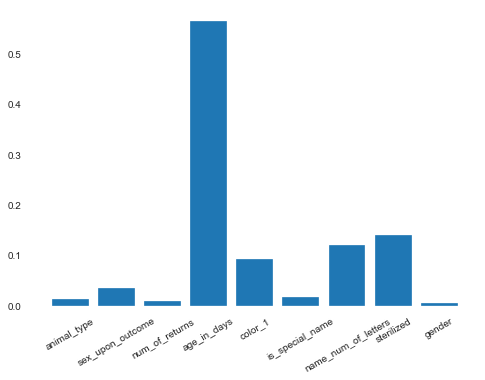

In [606]:
print("\n Feature importance array is: \n", model.feature_importances_ ) #print an array of importance values
plt.figure(figsize=(30, 20))

inds = range(len(model.feature_importances_))   #set up y axis values with feature importance array
fig,ax = plt.subplots()                          # call subplot to get ax handle 
rects = ax.bar(inds, model.feature_importances_) #intialize rects for bar graph
ax.set_xticks([ind for ind in inds])         # shift labels to right by 0.5 to prevent them from being at the leftmost edge of box
ax.set_xticklabels(list(X))               #put x axis labels as list of columns of features dataframe 
locs, labels = plt.xticks(); plt.setp(labels, rotation=30)  # to prevent label overlapping in x axis
plt.show()